In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

# Define data transformations (convert images to tensors, keeping values between [0, 1])
transform = transforms.Compose([
    transforms.ToTensor()  # Converts pixel values from [0, 255] to [0, 1]
])

# Download MNIST dataset
train_dataset = torchvision.datasets.MNIST(root="./data", train=True, transform=transform, download=True)
test_dataset = torchvision.datasets.MNIST(root="./data", train=False, transform=transform, download=True)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


In [237]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class MNIST_Net(nn.Module):
    def __init__(self):
        super(MNIST_Net, self).__init__()
        self.l1l4 = nn.Linear(784, 10, bias=True) 

        self.l1l2 = nn.Linear(784, 26, bias=True)  # Input: 784 → Hidden: 128
        self.l2l4 = nn.Linear(26, 10, bias=False) 

        self.l1l3 = nn.Linear(784, 3, bias=True)
        self.l2l3 = nn.Linear(26, 3, bias=False)
        self.l3l4 = nn.Linear(3, 10, bias=False)

    def forward(self, im):
        
        l1 = im.view(-1, 784) 
        global l1a
        l1a = [x + y for x, y in zip(l1a, l1.sum(dim=0).tolist())]

        l2 = F.relu(self.l1l2(l1))
        global l2a
        l2a = [x + y for x, y in zip(l2a, l2.sum(dim=0).tolist())]

        l3 = torch.matmul(l1, self.l1l3.weight.T) + torch.matmul(l2, self.l2l3.weight.T)
        l3 += self.l1l3.bias
        global l3a
        l3a = [x + y for x, y in zip(l3a, l3.sum(dim=0).tolist())]

        l4 = torch.matmul(l1, self.l1l4.weight.T) + torch.matmul(l2, self.l2l4.weight.T) + torch.matmul(l3, self.l3l4.weight.T)
        l4 += self.l1l4.bias
        global l4a
        l4a = [x + y for x, y in zip(l4a, l4.sum(dim=0).tolist())]
        
        return l4

# Initialize model
model = MNIST_Net()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
#model.load_state_dict(torch.load("model_weights.pth"))


MNIST_Net(
  (l1l4): Linear(in_features=784, out_features=10, bias=True)
  (l1l2): Linear(in_features=784, out_features=26, bias=True)
  (l2l4): Linear(in_features=26, out_features=10, bias=False)
  (l1l3): Linear(in_features=784, out_features=3, bias=True)
  (l2l3): Linear(in_features=26, out_features=3, bias=False)
  (l3l4): Linear(in_features=3, out_features=10, bias=False)
)

In [249]:
num_weights = sum(p.numel() for p in model.parameters())
print("Total number of params in the model:", num_weights)


Total number of params in the model: 30983


In [238]:
import torch.optim as optim

# Define loss function & optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

l1a = [0] * 784
l2a = [0] * 26
l3a = [0] * 3
l4a = [0] * 10

# Training loop
epochs = 5
for epoch in range(epochs):
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)  # Move data to GPU
        optimizer.zero_grad()  # Reset gradients
        outputs = model(images)
        loss = criterion(outputs, labels)  # Compute loss
        loss.backward()  # Backpropagation
        optimizer.step()  # Update weights

    print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}")

print("Training complete!")

# Save the model's state_dict
torch.save(model.state_dict(), "./model_weights.pth")


Epoch 1/5, Loss: 0.4039
Epoch 2/5, Loss: 0.2905
Epoch 3/5, Loss: 0.1256
Epoch 4/5, Loss: 0.1867
Epoch 5/5, Loss: 0.0973
Training complete!


In [239]:
correct = 0
total = 0

l1a = [0] * 784
l2a = [0] * 26
l3a = [0] * 3
l4a = [0] * 10

with torch.no_grad():  # Disable gradient calculations
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)  # Get predicted class
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

l1a = [x / len(test_loader.dataset) for x in l1a]
l2a = [x / len(test_loader.dataset) for x in l2a]
l3a = [x / len(test_loader.dataset) for x in l3a]
l4a = [x / len(test_loader.dataset) for x in l4a]

l1a = [l1a[i] * (model.l1l2.weight.abs().sum(dim=0).detach().numpy()[i] + model.l1l3.weight.abs().sum(dim=0).detach().numpy()[i] + model.l1l4.weight.abs().sum(dim=0).detach().numpy()[i]) for i in range(len(l1a))]
l2a = [l2a[i] * (model.l2l3.weight.abs().sum(dim=0).detach().numpy()[i] + model.l2l4.weight.abs().sum(dim=0).detach().numpy()[i]) for i in range(len(l2a))]
l3a = [l3a[i] * model.l3l4.weight.abs().sum(dim=0).detach().numpy()[i] for i in range(len(l3a))]

a = l1a + l2a + l3a + l4a

accuracy = 100 * correct / total
print(f"Test Accuracy: {accuracy:.2f}%")

Test Accuracy: 96.36%


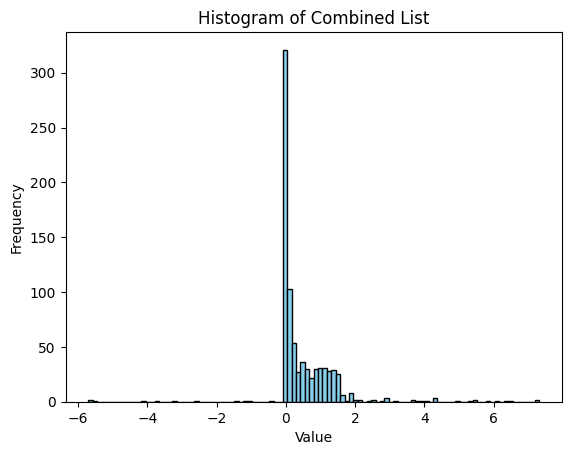

In [240]:
import matplotlib.pyplot as plt

# Plotting the histogram
plt.hist(a, bins=int(len(a)/8), color='skyblue', edgecolor='black')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram of Combined List')
plt.show()


In [241]:
len(a)

823

In [242]:
len([x for x in a[784:784 + len(l2a)]]) 

26

In [243]:
len([x for x in a[784:784 + len(l2a)] if abs(x) >= 1]) 

26

In [244]:
len([x for x in a[784 + len(l2a): 784 + len(l2a) + len(l3a)]]) 

3

In [245]:
len([x for x in a[784 + len(l2a): 784 + len(l2a) + len(l3a)] if abs(x) >= 1]) 

3